In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import feather
import warnings
import time
import sys
import datetime

from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', 1000)
from scipy.stats import mode
from scipy import stats
from sklearn import preprocessing

import re
import gc
from IPython.core.display import display, HTML

In [2]:
last_two_month = feather.read_dataframe('last_two_months')

In [3]:
last_two_month = last_two_month[last_two_month.month_order == 0]

In [4]:
def modeplus(x): return mode(x)[0]
def non_zero_percent(x): return x.count().sum() / x.size
def top_quarter_quantile(x): return x.quantile(q=0.1)
def bottom_quarter_quantile(x): return x.quantile(q=0.9)

In [5]:
agg_pars = {'authorized_flag':['mean','size','sum'],
            'city_id':[modeplus,'median'],
            'category_1':['mean','sum'],
            'installments':['sum','max','min','count','mean',bottom_quarter_quantile,top_quarter_quantile],
            'merchant_category_id':[modeplus,'median'],
            'purchase_amount':['mean','max','min','sum'],
            'state_id':[modeplus,'count'],
            'subsector_id':[modeplus,'count'],
            
            'no_city':['mean','sum'],
            'undefined_installments':['sum','mean'],
            'big_installments':['mean','sum'],
            'cat2_dum_0.0':['mean','sum'],
            'cat2_dum_1.0':['mean','sum'],
            'cat2_dum_2.0':['mean','sum'],
            'cat2_dum_3.0':['mean','sum'],
            'cat2_dum_4.0':['mean','sum'],
            'cat2_dum_5.0':['mean','sum'],
            'cat2_dum_nan':['mean','sum'],
            'cat3_dum_A':['mean','sum'],
            'cat3_dum_B':['mean','sum'],
            'cat3_dum_C':['mean','sum'],
            'cat3_dum_nan':['mean','sum'],
            
            'purchase_amount_unusual':['mean','sum'],
            'payment_per_month':['mean','max','min','count',non_zero_percent,top_quarter_quantile,bottom_quarter_quantile]}

In [6]:
agged_author_flag = last_two_month.groupby(['card_id']).agg(agg_pars)

In [7]:
train = pd.read_csv('C:\\kdata\\train.csv',usecols=['card_id','target'])
test = pd.read_csv('C:\\kdata\\test.csv',usecols=['card_id'])

In [8]:
train = pd.merge(train,agged_author_flag,how='left',on='card_id')
test = pd.merge(test,agged_author_flag,how='left',on='card_id')

C:\Users\User\Anaconda3\envs\ml\lib\site-packages\pandas\core\reshape\merge.py:544: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
C:\Users\User\Anaconda3\envs\ml\lib\site-packages\pandas\core\reshape\merge.py:544: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


NameError: name 'sns_plot' is not defined

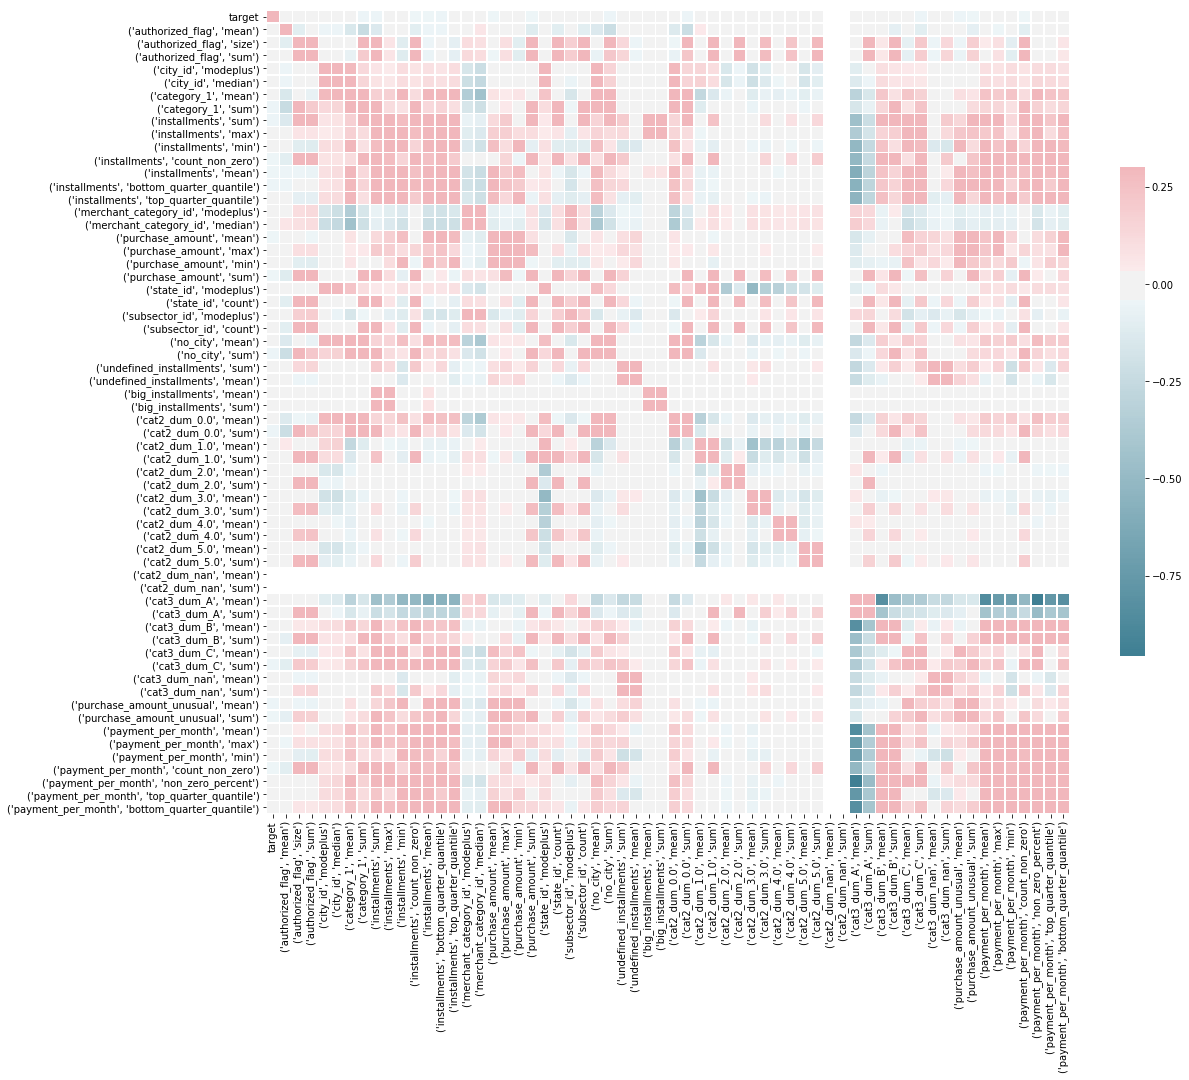

In [9]:
corr = train.corr()
cmap = sns.diverging_palette(220, 10, as_cmap=True)
f, ax = plt.subplots(figsize=(18, 18))
sns.heatmap(corr,  cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


In [13]:
train.columns = [x if (len(x) != 2) else '_'.join(x) for x in train.columns.values]

In [24]:
new_train = train.drop(['cat3_dum_nan_mean','cat3_dum_nan_sum','cat2_dum_nan_mean','cat2_dum_nan_sum'],axis=1)

In [25]:
corr = new_train.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

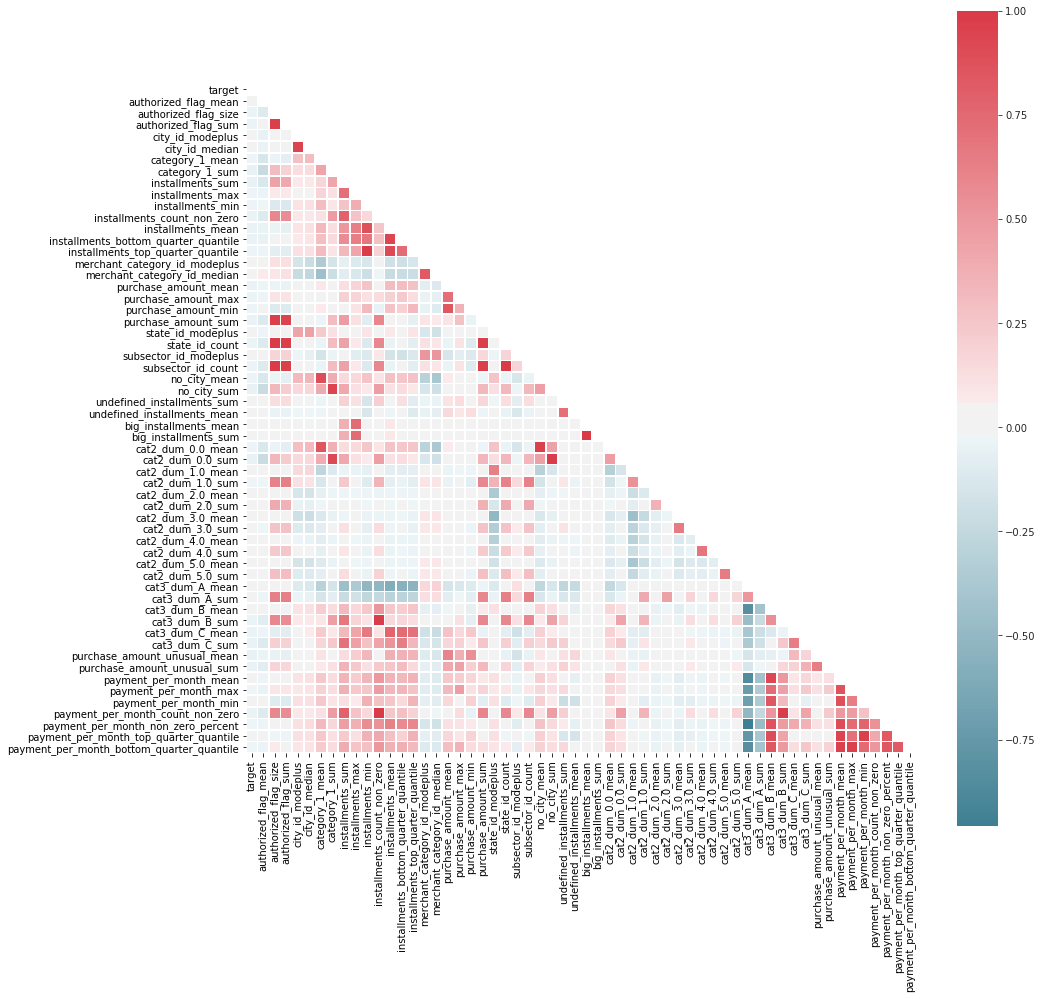

In [42]:
f, ax = plt.subplots(figsize=(15, 15))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, square=True,cmap=cmap,linewidths=0.7,cbar_kws={"ticks": None})
    fig = ax.get_figure()
    fig.savefig('corr_matrix.png', dpi=228)

In [20]:
target = train['target']
del train['target']

In [21]:
features = [c for c in train.columns if c not in ['card_id', 'first_active_month']]
categorical_feats = [x for x in train.columns.values if re.search(x,'modeplus')]

In [22]:
outputs = []
ptest = 1
for ptest in range(1):
    param = {
            'num_leaves': 111, #checked
             'num_threads': 4,
             'max_bin': 75, #checked
             'min_data_in_leaf': 100, #checked 
             'objective':'regression',
             'max_depth': 9, #checked #9
             'tree_learner':'data',
             'learning_rate': 0.003,
             "boosting": "rf", #dart, gbdt
             "feature_fraction": 0.75, #checked
             "bagging_freq": 5,
             "bagging_fraction": 0.70, #checked
             "bagging_seed": 11,
             "metric": 'rmse',
#             "lambda_l1": 0.26, #checked
#            'lambda_l2': 0.3, #checked
             "random_state": 77,
             "verbosity": -1,
             "device":"gpu",
             'gpu_device_id':0,
             'gpu_platform_id':1,
             'gpu_use_dp':True,
            }

    
    folds = KFold(n_splits=5, shuffle=True, random_state=15)
    oof = np.zeros(len(train))
    predictions = np.zeros(len(test))
    start = time.time()
    feature_importance_df = pd.DataFrame()

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
        print("fold n°{}".format(fold_))
        
        trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                               label=target.iloc[trn_idx],
                               categorical_feature=categorical_feats
                              )
        val_data = lgb.Dataset(train.iloc[val_idx][features],
                               label=target.iloc[val_idx],
                               categorical_feature=categorical_feats
                              )


        clf = lgb.train(param,
                        trn_data,
                        15000,
                        valid_sets = [trn_data, val_data],
                        verbose_eval=1000,
                        early_stopping_rounds = 1000)

        oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = features
        fold_importance_df["importance"] = clf.feature_importance()
        fold_importance_df["fold"] = fold_ + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

        predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits
    errr = mean_squared_error(oof, target)**0.5
    print("CV score: {:<8.5f}".format(errr))
    outputs.append(f'{ptest}, {errr}')
    print(f'\n^ {ptest} - num leaves^ \n')

fold n°0


C:\Users\User\Anaconda3\envs\ml\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 1000 rounds.
[1000]	training's rmse: 3.80316	valid_1's rmse: 3.86498
Early stopping, best iteration is:
[245]	training's rmse: 3.80312	valid_1's rmse: 3.86462
fold n°1


C:\Users\User\Anaconda3\envs\ml\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 1000 rounds.
[1000]	training's rmse: 3.82387	valid_1's rmse: 3.78799
Early stopping, best iteration is:
[44]	training's rmse: 3.82523	valid_1's rmse: 3.78756
fold n°2


C:\Users\User\Anaconda3\envs\ml\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 1000 rounds.
[1000]	training's rmse: 3.82756	valid_1's rmse: 3.76118
Early stopping, best iteration is:
[96]	training's rmse: 3.82744	valid_1's rmse: 3.76202
fold n°3


C:\Users\User\Anaconda3\envs\ml\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 1000 rounds.
[1000]	training's rmse: 3.7744	valid_1's rmse: 3.97463
Early stopping, best iteration is:
[119]	training's rmse: 3.77429	valid_1's rmse: 3.97502
fold n°4


C:\Users\User\Anaconda3\envs\ml\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 1000 rounds.
[1000]	training's rmse: 3.82425	valid_1's rmse: 3.77543
Early stopping, best iteration is:
[149]	training's rmse: 3.82378	valid_1's rmse: 3.77577
CV score: 3.83382 

^ 0 - num leaves^ 



In [23]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

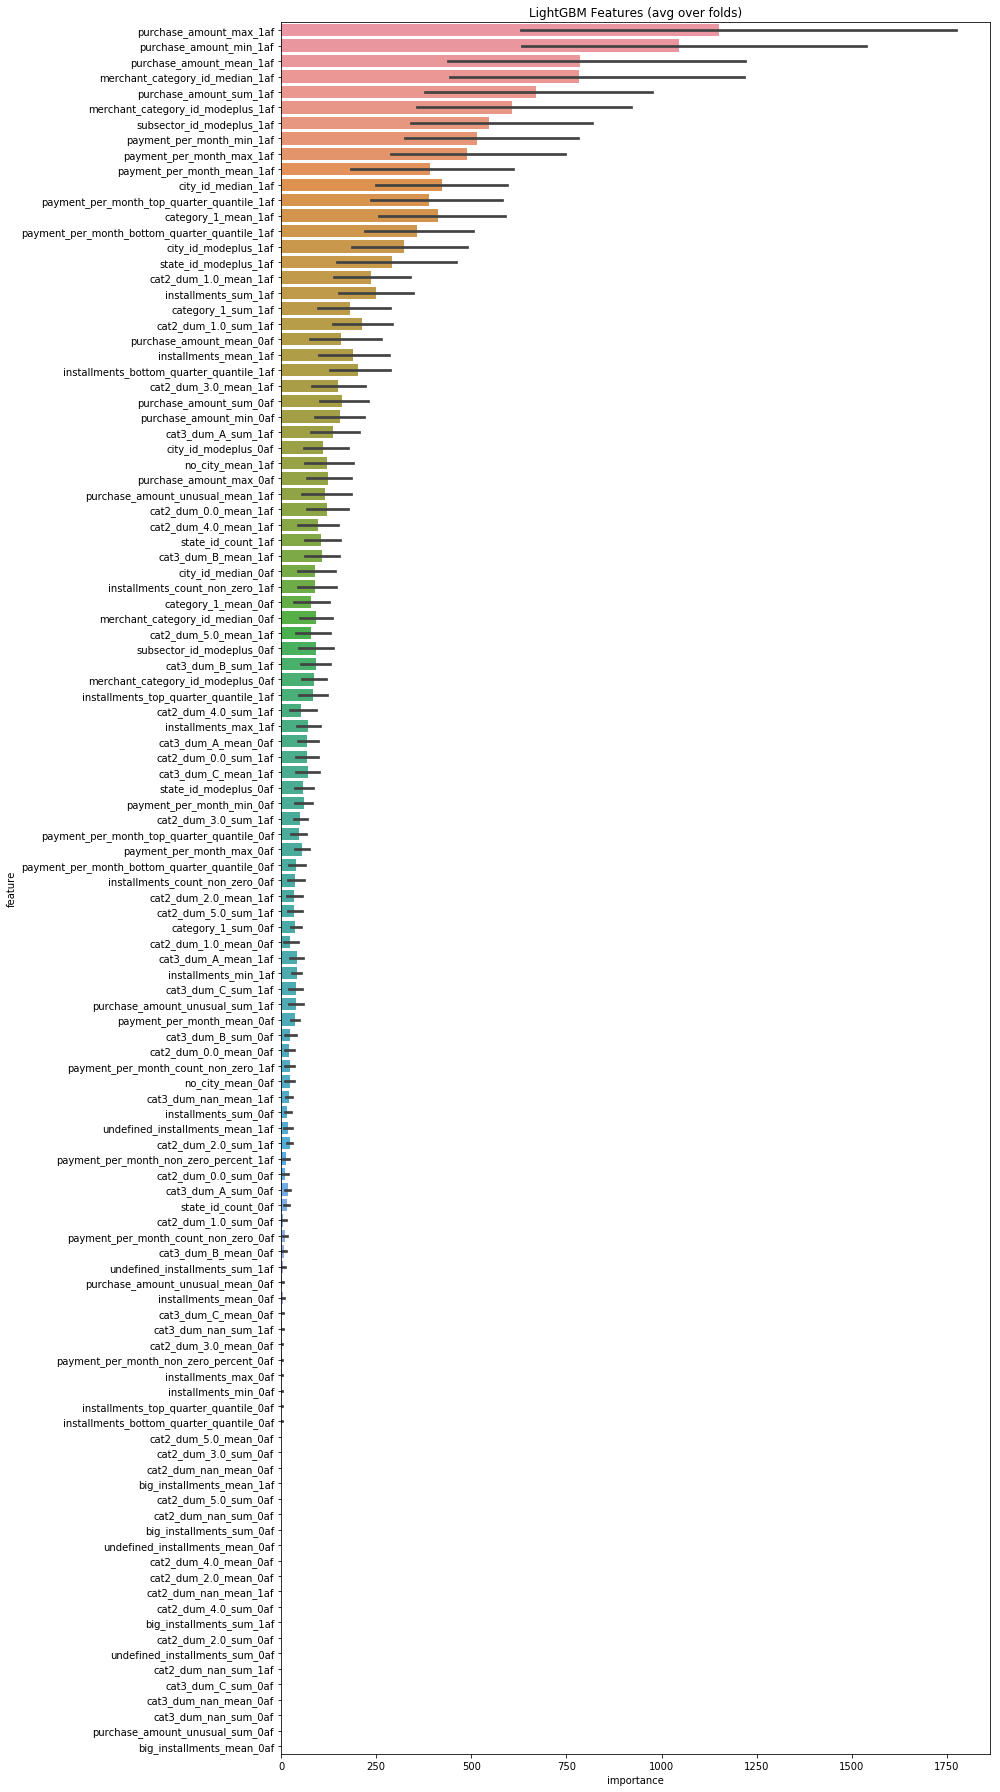

In [24]:
plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')